In [33]:
import gmsh
from matplotlib.font_manager import dataclasses
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import sys

a_b=0.5
mesh_shape=1
mesh_size=10
show=True


def create_mesh(a_b=0.05, mesh_shape=1, mesh_size=8, show=False):
    # 初始化gmsh
    gmsh.initialize()
    gmsh.model.add('2D shape')
    # 创建正方形
    rect_tag = gmsh.model.occ.addRectangle(0, 0, 0, 40, 40)

    b = 20
    a = b*a_b
    # 创建椭圆
    ellipse_tag = gmsh.model.occ.addEllipse(0, 0, 0, b, a)

    # 旋转椭圆90度
    center = [0, 0, 0]
    axis_direction = [0, 0, 1]  # Z轴方向
    angle = 90 * np.pi / 180  # 将角度转换为弧度
    gmsh.model.occ.rotate([(1, ellipse_tag)], center[0], center[1], center[2], axis_direction[0], axis_direction[1], axis_direction[2], angle)

    # 创建一个椭圆的线循环
    ellipse_loop = gmsh.model.occ.addCurveLoop([ellipse_tag])

    # 创建一个椭圆面
    ellipse_surface = gmsh.model.occ.addPlaneSurface([ellipse_loop])

    # 对椭圆进行裁剪
    cut_tag, _ = gmsh.model.occ.cut([(2, rect_tag)], [(2, ellipse_surface)])

    gmsh.option.setNumber("General.Terminal", 0)
    # gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 1)
    gmsh.option.setNumber("Mesh.Algorithm",8)

    # gmsh.option.setNumber("Mesh.ElementOrder", 2)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 3)
    gmsh.option.setNumber("Mesh.RecombineAll", mesh_shape)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", mesh_size)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", mesh_size)


    # 同步模型
    gmsh.model.occ.synchronize()

    # 生成2D网格
    gmsh.model.mesh.generate(2)

    # 保存模型和网格
    gmsh.write('2Dshape.msh')

    # 获取所有的节点信息（节点标签，节点坐标和参数化坐标）
    node_tags, node_coords, parametric_coords = gmsh.model.mesh.getNodes()
    # print(node_tags)

    # 获取所有的单元信息（元素类型，元素标签和节点连接性）
    element_types, element_tags, element_nodes = gmsh.model.mesh.getElements()

    # 因为getNodes和getElements返回的数据都是flattened arrays（扁平化数组），我们需要根据节点或单元的维度来reshape数组。
    node_coords = node_coords.reshape(-1, 3)[:, :2]
    # print(node_coords)
    # print(element_types)
    # print(len(element_tags[1]))
    # print(element_nodes )

    if show:
        gmsh.fltk.run()

    # 清理
    gmsh.finalize()
    assert len(element_types)<=3, "The mesh method is wrong, the elements have {} types".format(len(element_types))

    return node_coords, element_nodes[1]-1 

def in_ellipse(xy, a, b):
    x = xy[0]
    y = xy[1]
    return (x/b)**2 + (y/a)**2 <= 1+1e-3

@dataclass
class Node:
    xy: tuple
    id: int
    type='center'
    BC = [0, 0]

def Boundary(node_coords, a_b):
    b=20
    a = b*a_b
    resiual = 1e-3
    Node_list = []
    for i in range(len(node_coords)):
        Node_list.append(Node(xy=node_coords[i],id=i))

    for i in range(len(Node_list)):
        # Check ellipse node
        if in_ellipse(Node_list[i].xy, a, b):
            Node_list[i].type = 'ellipse'
            Node_list[i].BC = [-1, -1]
        # Check left edge
        if abs(Node_list[i].xy[0]-0)<=resiual:
            if abs(Node_list[i].xy[1] - a) <= resiual:
                Node_list[i].type ='lbc'
                Node_list[i].BC = [1, -1]
            else:
                Node_list[i].type = 'le'
                Node_list[i].BC = [1, -1]
        # Check right edge
        elif abs(Node_list[i].xy[0] - 40 )<=resiual:
            Node_list[i].type = 're'
            Node_list[i].BC = [-1, -1] 
        # Check bottom edge
        if abs(Node_list[i].xy[1]-0) <= resiual:
            if abs(Node_list[i].xy[0]-b) <= resiual:
                Node_list[i].type='blc'
                Node_list[i].BC = [-1, 1]
            elif Node_list[i].type=='re':
                Node_list[i].type = 'rbc'
                Node_list[i].BC = [-1, 1]
            else:
                Node_list[i].type = 'be'
                Node_list[i].BC = [-1, 1]

        # Check top edge
        if abs(Node_list[i].xy[1]-40)<=resiual:

            if Node_list[i].type=='le':
                Node_list[i].type ='ltc'
                Node_list[i].BC = [1, -1]
            elif Node_list[i].type == 're':
                Node_list[i].type='rtc'
                Node_list[i].BC = [-1, -1]
            else:
                Node_list[i].type = 'te'
                Node_list[i].BC = [-1, -1]
                
    return Node_list

    


11
33
[ 6 10  9  1 10  2  6  9  7  8  9  5  7  9  4  5  0  8  9 10  5  2 10  6
  4  9  8  7  3  6  5 10  1]
11
0 [1.00000000e+01 4.94987833e-13] be [-1, 1]
1 [2.22044605e-15 2.00000000e+01] le [1, -1]
2 [ 0. 40.] ltc [1, -1]
3 [40. 40.] rtc [-1, -1]
4 [40.  0.] rbc [-1, 1]
5 [ 8.04116374 11.88943829] center [0, 0]
6 [20. 40.] te [-1, -1]
7 [40. 20.] re [-1, -1]
8 [25.  0.] be [-1, 1]
9 [23.33333333 16.66666667] center [0, 0]
10 [10.27489941 25.71122099] center [0, 0]
<class 'numpy.ndarray'>
None


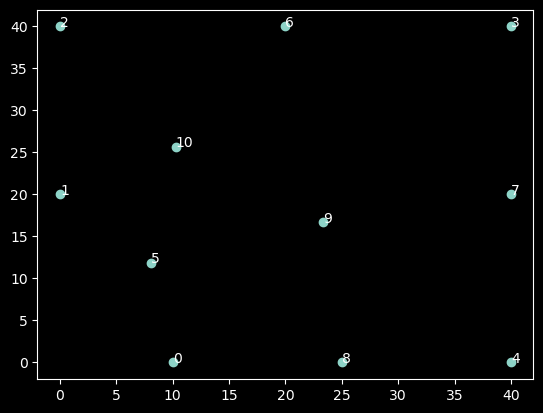

In [32]:
import csv

a_b = 0.5
mesh_shape=0
mesh_size= 20
show = False
node_coords, element_nodes =  create_mesh(a_b=a_b, mesh_shape=mesh_shape, mesh_size=mesh_size, show=show)
Nodes_list = Boundary(node_coords, a_b)
print(len(Nodes_list))
print(len(element_nodes))
print(element_nodes)
print(len(np.reshape(element_nodes, (-1, 3))))
# print(im=esh_ori.getNodes())
plt.scatter(node_coords[:, 0], node_coords[:, 1])
for node in Nodes_list:
    print(node.id, node.xy, node.type, node.BC)

with open('nodes_data.txt', 'w') as file:
    # 遍历列表中的每个节点
    for node in Nodes_list:
        # 将每个节点的属性写入文件
        # 使用逗号或其他分隔符分隔每个属性，以便于阅读和未来的数据解析
        file.write(f"{node.id}, {node.xy}, {node.type}, {node.BC}\n")
    file.write("element nodes: " + ' '.join(str(x) for x in element_nodes))

import json

# 假设 Nodes_list 和 element_nodes 已经定义
nodes_data = []

for node in Nodes_list:
    node_dict = {
        "id": node.id,
        "x": node.xy[0],
        "y": node.xy[1],
        "type": node.type,
        "BC": list(node.BC)  # 确保 BC 是列表或元组
    }
    nodes_data.append(node_dict)
def check_data(data):
    if isinstance(data, (dict, list, tuple, str, int, float, bool, type(None))):
        if isinstance(data, (list, tuple)):
            for item in data:
                check_data(item)
        elif isinstance(data, dict):
            for k, v in data.items():
                check_data(v)
    else:
        print(f"Unsupported data type: {type(data)}")

# 在序列化之前检查数据


# 添加 element nodes
nodes_data.append({"element nodes": element_nodes.tolist()})
print(type(element_nodes))

print(check_data(nodes_data))

with open('nodes_data.json', 'w') as file:
    json.dump(nodes_data, file, indent=4)


for (x, y), node in zip(node_coords, Nodes_list):
        # 在指定的坐标处显示文本
        plt.text(x, y, node.id) 

# 显示图形
# plt.show()


In [34]:
import numpy as np
order = 2
xi, wi = np.polynomial.legendre.leggauss(order)
points = [(x, y) for x in xi for y in xi]
weights = [wx * wy for wx in wi for wy in wi]
points, weights

([(-0.5773502691896257, -0.5773502691896257),
  (-0.5773502691896257, 0.5773502691896257),
  (0.5773502691896257, -0.5773502691896257),
  (0.5773502691896257, 0.5773502691896257)],
 [1.0, 1.0, 1.0, 1.0])

0.5773502691896258